In [1]:
from model import * 
from train_model import * 


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



Epoch 1/1000 | E=-0.46 C=0.61413 Error=50.00%:   0%|          | 0/1000 [00:00<?, ?epoch/s]

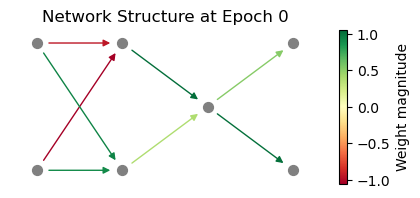

Epoch 250/1000 | E=-0.52 C=0.00000 Error=0.00%:  25%|██▍       | 249/1000 [00:01<00:03, 213.76epoch/s]

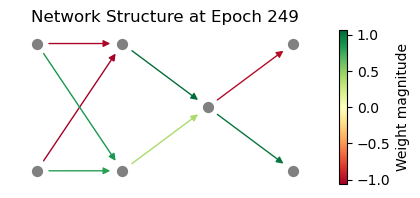

Epoch 500/1000 | E=-0.52 C=0.00000 Error=0.00%:  50%|█████     | 500/1000 [00:02<00:02, 222.62epoch/s]

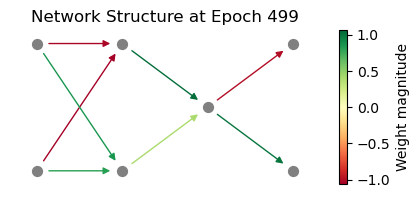

Epoch 750/1000 | E=-0.52 C=0.00000 Error=0.00%:  75%|███████▍  | 749/1000 [00:03<00:01, 228.61epoch/s]

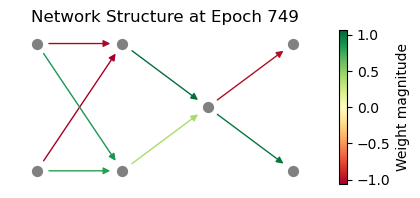

Epoch 1000/1000 | E=-0.52 C=0.00000 Error=0.00%: 100%|█████████▉| 999/1000 [00:04<00:00, 222.95epoch/s]

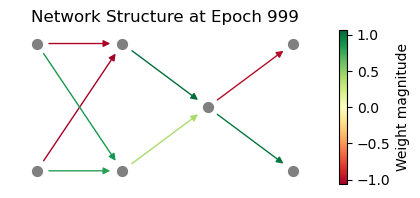

Epoch 1000/1000 | E=-0.52 C=0.00000 Error=0.00%: 100%|██████████| 1000/1000 [00:04<00:00, 208.78epoch/s]


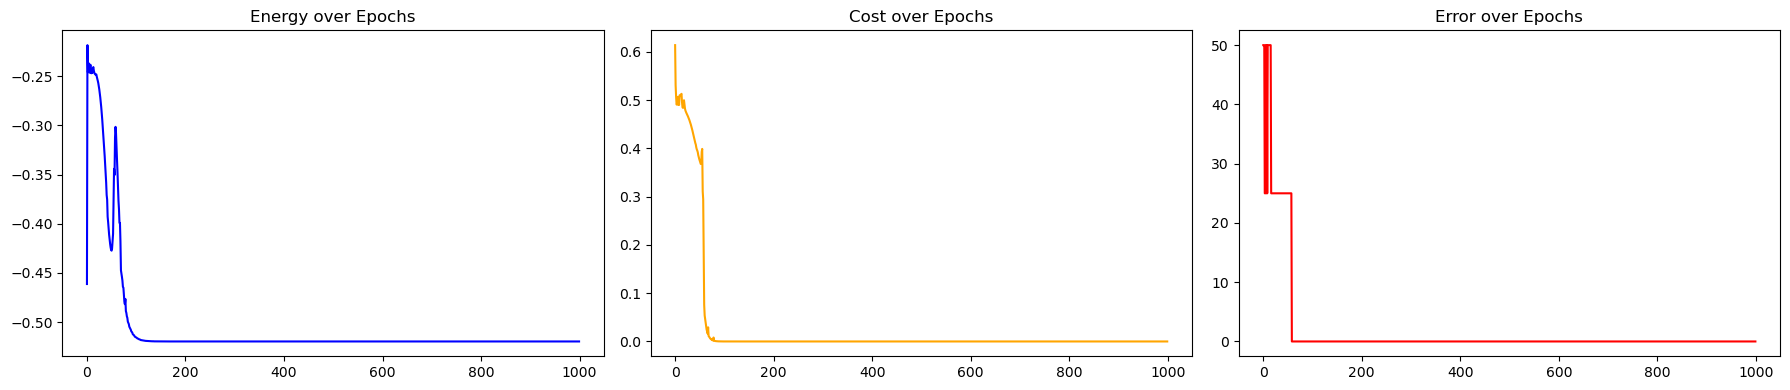

In [7]:
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]] * 10, dtype=np.float32)
xor_y = np.array([0, 1, 1, 0] * 10, dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)

# small nets can solve xor
xor_net = Network(
    name="xor_net",
    external_world=xor_world,
    hyperparameters={
        "hidden_sizes": [2, 1],
        "output_size": 2,
        "batch_size": 4,
        "n_epochs": 1000,
        "n_it_neg": 10,
        "n_it_pos": 10,
        "alphas": [np.float32(0.1), np.float32(0.1),  np.float32(0.05)]
    }
)

# Train the network
train_net(xor_net, plot_graph= True)

